In [1]:
# Import all packages
import pandas as pd
import numpy as np
rn = np.random
rn.seed(1)
import matplotlib.pyplot as plt
import docplex
from docplex.mp.model import Model

## Part a: CLSP Optimization Problem

#### Create a model instance

In [2]:
model = Model(name='CLSP with multiple products')

#### Define sets and indices

In [3]:
# Read excel file
df = pd.read_excel('lotsizing.xlsx', sheet_name=['demand', 'costs', 'production_parameters', 'production_coefficients', 'starting_inventories'])

In [8]:
# Products and periods
products = [1, 2]
periods = [1, 2, 3, 4, 5]

# Demand of each product in each periods
demand = df['demand'].set_index('period')

# Production capacity per period
c = df['production_parameters'].set_index('parameter').loc['capacity per period', 'value']

# Inventory holding cost per unit per product per period
c_int = df['costs'].set_index('product')['inventory costs per unit and period']

# Setup cost per setup process for product
c_setup = df['costs'].set_index('product')['setup costs per setup']

# BigM
bigM = df['production_parameters'].set_index('parameter').loc['BigM', 'value']

# Capacity consumption for product
a = df['production_coefficients'].set_index('product')['production coefficient']

# Initial inventory level
L0 = df['starting_inventories'].set_index('product')['initial inventory']

#### Define decision variables

In [9]:
# Production quantity per product per period
X = model.integer_var_matrix(products, periods, name='Production quantity')

# Inventory level of each product at the end of each period
Y = model.integer_var_matrix(products, periods, name='Inventory level')

# Setup occurs or not for each product per period
T = model.binary_var_matrix(products, periods, name='Setup or not')

#### Define constraints

In [10]:
# Inventory level equation
for t in periods:
    if t == 1:
        model.add_constraints(Y[p, 1] == L0[p] + X[p, 1] - demand.loc[p, 1] for p in products)
    else:
        model.add_constraints(Y[p, t] == Y[p, t-1] + X[p,t] - demand.loc[p,t] for p in products)

# Setup or not
for t in periods:
    for p in products:
        model.add_constraint(X[p,t] <= bigM * T[p,t])

# Production capacity
for t in periods:
    model.add_constraint(model.sum(a[p] * X[p,t] for p in products) <= c)

# Non-negative values
model.add_constraints(X[p,t] >= 0 for p in products for t in periods)
model.add_constraints(Y[p,t] >= 0 for p in products for t in periods)

[docplex.mp.LinearConstraint[](Inventory level_1_1,GE,0),
 docplex.mp.LinearConstraint[](Inventory level_1_2,GE,0),
 docplex.mp.LinearConstraint[](Inventory level_1_3,GE,0),
 docplex.mp.LinearConstraint[](Inventory level_1_4,GE,0),
 docplex.mp.LinearConstraint[](Inventory level_1_5,GE,0),
 docplex.mp.LinearConstraint[](Inventory level_2_1,GE,0),
 docplex.mp.LinearConstraint[](Inventory level_2_2,GE,0),
 docplex.mp.LinearConstraint[](Inventory level_2_3,GE,0),
 docplex.mp.LinearConstraint[](Inventory level_2_4,GE,0),
 docplex.mp.LinearConstraint[](Inventory level_2_5,GE,0)]

#### Define linear expression

In [11]:
# Total cost = total inventory cost + total setup cost
Z = model.sum(c_int[p] * Y[p,t] + c_setup[p] * T[p,t] for p in products for t in periods)

#### Define objective function

In [12]:
model.minimize(Z)

#### Solve model

In [13]:
model.solve()

docplex.mp.solution.SolveSolution(obj=591120,values={Production quantity..

#### Store result in a DataFrame

In [16]:
# Initialize an empty dataframe
result = pd.DataFrame(index=['Prod quant p1', 'Prod quant p2', 'Total production', 'Inventory p1', 'Inventory p2', 'Inventory costs', 'Setup costs', 'Total costs', '%setup/total'])

# Store result in dataframe
for t in periods:
    result.loc['Prod quant p1', t] = X[1,t].solution_value
    result.loc['Prod quant p2', t] = X[2,t].solution_value
    result.loc['Total production', t] = result.loc['Prod quant p1', t] + result.loc['Prod quant p2', t]
    result.loc['Inventory p1', t] = Y[1,t].solution_value
    result.loc['Inventory p2', t] = Y[2,t].solution_value
    result.loc['Inventory costs', t] = result.loc['Inventory p1', t] * c_int[1] + result.loc['Inventory p2', t] * c_int[2]
    result.loc['Setup costs', t] = sum(c_setup[p] * T[p,t].solution_value for p in products)
    result.loc['Total costs', t] = result.loc['Inventory costs', t] + result.loc['Setup costs', t]
    result.loc['%setup/total', t] = result.loc['Setup costs', t] / result.loc['Total costs', t]

result['All periods'] = result.sum(axis=1)
result.loc['%setup/total', 'All periods'] = result.loc['Setup costs', 'All periods'] / result.loc['Total costs', 'All periods']
result

,1,2,3,4,5,All periods
Prod quant p1,117060.000000,44720.0,0.0,0.000000,0.0,161780.000000
Prod quant p2,0.000000,135280.0,96000.0,126000.000000,180000.0,537280.000000
Total production,117060.000000,180000.0,96000.0,126000.000000,180000.0,699060.000000
Inventory p1,54560.000000,0.0,0.0,0.000000,0.0,54560.000000
Inventory p2,0.000000,0.0,0.0,31000.000000,0.0,31000.000000
Inventory costs,109120.000000,0.0,0.0,62000.000000,0.0,171120.000000
Setup costs,70000.000000,140000.0,70000.0,70000.000000,70000.0,420000.000000
Total costs,179120.000000,140000.0,70000.0,132000.000000,70000.0,591120.000000
%setup/total,0.390799,1.0,1.0,0.530303,1.0,0.710516


## Part b: Sensitivity test

In [17]:
sensitivity_test = pd.DataFrame(columns=['Inventory costs i', 'Total costs'])

for i in range(0, 21, 1):
    Z = model.sum(i * Y[p,t] + c_setup[p] * T[p,t] for p in products for t in periods)
    
    model.minimize(Z)
    
    model.solve()
    
    sensitivity_test.loc[i-1, 'Inventory costs i'] = i
    sensitivity_test.loc[i-1, 'Total costs'] = model.objective_value

sensitivity_test

,Inventory costs i,Total costs
-1,0,280000.0
0,1,480280.0
1,2,591120.0
2,3,676680.0
3,4,762240.0
4,5,847800.0
5,6,933360.0
6,7,1018920.0
7,8,1104480.0
8,9,1190040.0


Text(0, 0.5, 'Total costs')

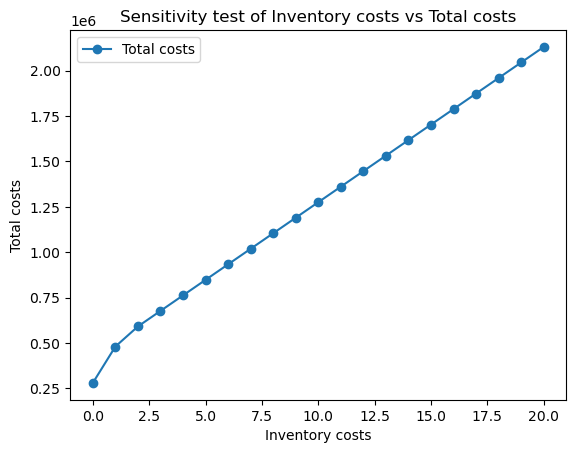

In [19]:
# Visualize sensitivity test result
sensitivity_test.plot(x='Inventory costs i', y='Total costs', marker='o')

plt.title('Sensitivity test of Inventory costs vs Total costs')
plt.xlabel('Inventory costs')
plt.ylabel('Total costs')

Inventory costs and total costs are nearly perfect linearly related. This is due to the large demand, therefore, no matter how much the inventory cost per unit change, the optimal production quantity remains the same, leanding to the linear relation between inventory costs and total costs.